Universidad del Valle de Guatemala <br>
28/01/2022 <br>
Minería de Datos # 20 

# Hoja de Trabajo 2
## Clustering

**Integrantes:**<br>
Walter Saldaña 19897 <br>
José Gutierrez 19111 <br>
Javier Cotto 19324 <br>

Importar modulos

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sb
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import pyclustertend 
import random

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

Cargar la base de datos a pandas

In [80]:
datos = pd.read_csv('movies.csv', encoding='unicode_escape')
datos.head()

,id,budget,genres,homePage,productionCompany,productionCompanyCountry,productionCountry,revenue,runtime,video,...,popularity,releaseDate,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount
0,5,4000000,Crime|Comedy,https://www.miramax.com/movie/four-rooms/,Miramax|A Band Apart,US|US,United States of America,4257354.0,98,False,...,20.880,1995-12-09,5.7,2077,2,2,1,25,15,9
1,6,21000000,Action|Thriller|Crime,NaN,Universal Pictures|Largo Entertainment|JVC,US|US|JP,Japan|United States of America,12136938.0,110,False,...,9.596,1993-10-15,6.5,223,3,3,2,15,3,9
2,11,11000000,Adventure|Action|Science Fiction,http://www.starwars.com/films/star-wars-episod...,Lucasfilm|20th Century Fox,US|US,United States of America,775398007.0,121,NaN,...,100.003,1977-05-25,8.2,16598,3,2,1,105,5,62
3,12,94000000,Animation|Family,http://movies.disney.com/finding-nemo,Pixar,US,United States of America,940335536.0,100,NaN,...,134.435,2003-05-30,7.8,15928,2,1,1,24,5,18
4,13,55000000,Comedy|Drama|Romance,NaN,Paramount|The Steve Tisch Company,US|,United States of America,677387716.0,142,False,...,58.751,1994-07-06,8.5,22045,3,2,1,76,18,48


## 1) Preprocesamiento de datos
Remover variables cualitativas que no aportan, ya que no son categóricas, y sus frecuencias no pueden ser clasificadas.

In [81]:
datos = datos.drop(["id", "originalTitle", "originalLanguage", "title", "homePage", "video", "director", "genres", "productionCompany", "productionCompanyCountry", "productionCountry", "actors", "actorsPopularity", "actorsCharacter", "releaseDate", "castMenAmount", "castWomenAmount", "productionCoAmount", "productionCountriesAmount", "actorsAmount", "genresAmount"], axis=1)
datos.head()

,budget,revenue,runtime,popularity,voteAvg,voteCount
0,4000000,4257354.0,98,20.880,5.7,2077
1,21000000,12136938.0,110,9.596,6.5,223
2,11000000,775398007.0,121,100.003,8.2,16598
3,94000000,940335536.0,100,134.435,7.8,15928
4,55000000,677387716.0,142,58.751,8.5,22045


### Resumen estadístico de las variables

In [82]:
datos.describe()

,budget,revenue,runtime,popularity,voteAvg,voteCount
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.855163e+07,5.673793e+07,100.268100,51.393907,6.483490,1342.381800
std,3.662669e+07,1.495854e+08,27.777829,216.729552,0.984274,2564.196637
min,0.000000e+00,0.000000e+00,0.000000,4.258000,1.300000,1.000000
25%,0.000000e+00,0.000000e+00,90.000000,14.577750,5.900000,120.000000
50%,5.000000e+05,1.631245e+05,100.000000,21.905500,6.500000,415.000000
75%,2.000000e+07,4.479661e+07,113.000000,40.654000,7.200000,1316.000000
max,3.800000e+08,2.847246e+09,750.000000,11474.647000,10.000000,30788.000000


### Análisis de la columna BUDGET

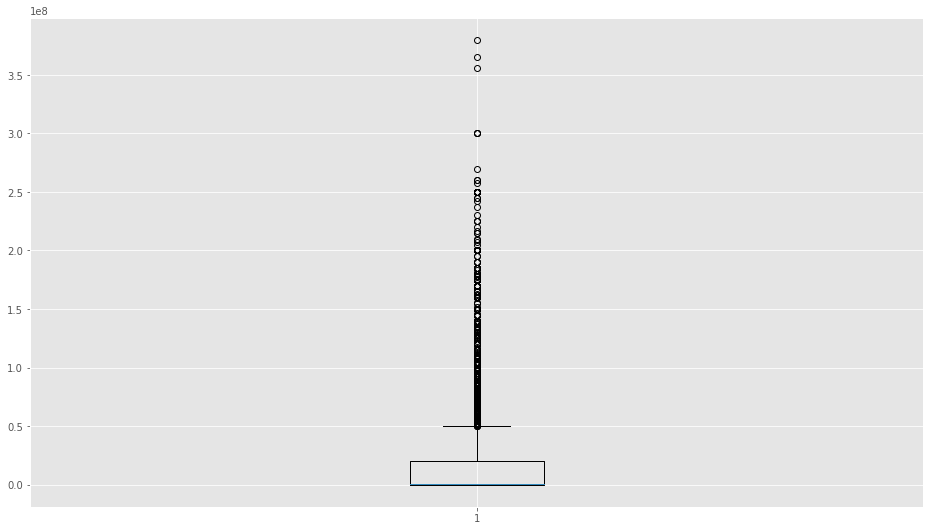

In [83]:
plt.boxplot(datos.budget)
plt.show()

Eliminar datos atípicos

In [87]:
indexes = datos[datos['budget'] < 5e5].index
datos.drop(indexes, inplace=True)

Q1 = datos.budget.quantile(0.25)
Q3 = datos.budget.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['budget'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['budget'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

datos

,budget,revenue,runtime,popularity,voteAvg,voteCount
0,4000000,4257354.0,98,20.880,5.7,2077
1,21000000,12136938.0,110,9.596,6.5,223
2,11000000,775398007.0,121,100.003,8.2,16598
4,55000000,677387716.0,142,58.751,8.5,22045
5,15000000,356296601.0,122,33.589,8.0,9951
...,...,...,...,...,...,...
9720,5308245,3468053.0,89,128.636,4.8,39
9754,20000000,0.0,95,23.674,7.3,89
9773,12400000,0.0,111,751.378,6.1,22
9778,1000000,0.0,0,22.204,2.0,1


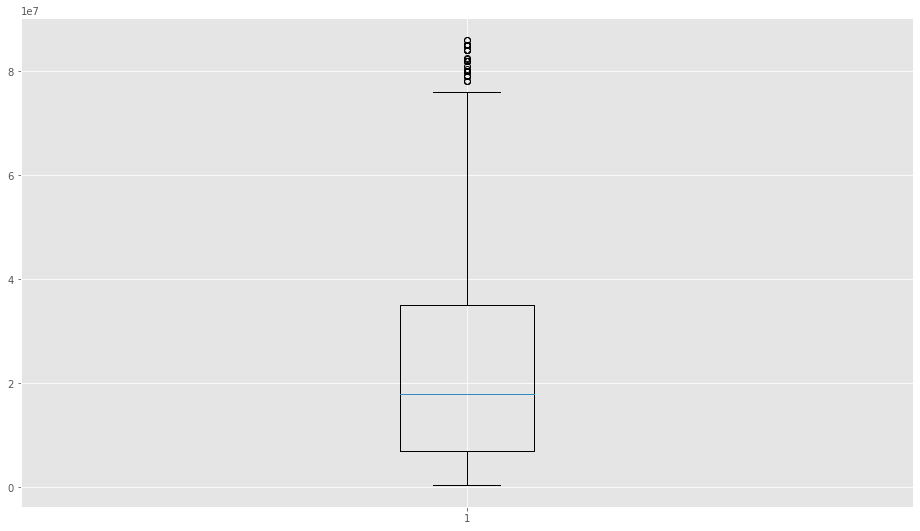

In [88]:
plt.boxplot(datos.budget)
plt.show()

## 2) Tendencia al agrupamiento

         budget       revenue
163   300000000  9.610000e+08
716   380000000  1.045714e+09
4710  365000000  1.405404e+09
4953  300000000  6.579243e+08
5952  356000000  2.797801e+09
5953  300000000  2.046240e+09

0.6913917868746702


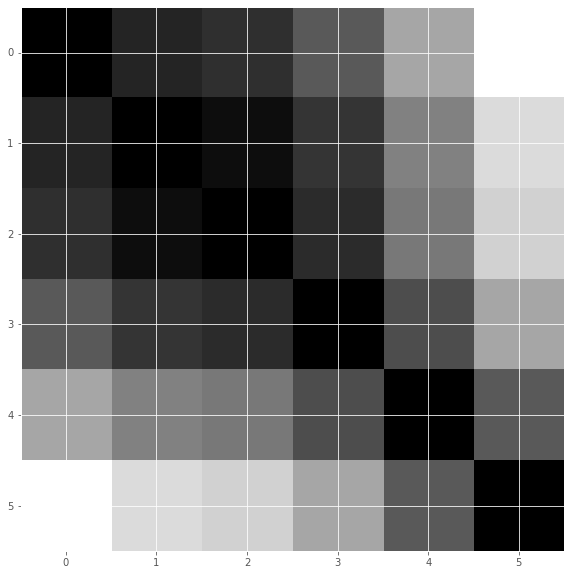

In [35]:
primer_agrupamiento = datos
primer_agrupamiento = primer_agrupamiento.drop(["runtime", "popularity", "voteCount"], axis=1)
print(primer_agrupamiento)
print()
print(pyclustertend.hopkins(primer_agrupamiento,len(primer_agrupamiento)))
pyclustertend.vat(primer_agrupamiento)

 ## Saber cuantas filas hay de cada categoría

In [ ]:
datos.groupby('Specie').size()

 Los datos están balanceados 50 para cada categoría

In [ ]:
datos.drop(['Specie'],1).hist()
plt.show()

In [ ]:
X = np.array(datos[['Petal.length','Petal.width','Sepal.length', 'Sepal.width']])
Y = np.array(datos[['Specie']])
X.shape

 ## ¿Hacemos Agrupamiento?

 Lo primero que vamos a hacer es verificar si vale la pena hacer el agrupapiento de los datos. Para esto utilizamos el estadístico de Hopkings. Lo que se busca es que el valor de este dato no sea igual a 0.5, lo que significa que los datos son aleatorios por lo que no tiene sentido hacer agrupamiento.

In [ ]:
random.seed(150)
X_scale=sklearn.preprocessing.scale(X)
# X = X_scale
pyclustertend.hopkins(X,len(X))

 Como se puede observar el estadístico de hopkings no es igual a 0.5 por lo que se dice que es factible hacer agrupamiento.

 Lo podemos verificar usando el método gráfico. Haremos un mapa de calor con las distancias para ver si hay algún patró o todo se ve aleatorio. Este mapa de valor se llama "Evaluación Visual de Tendencia" o VAT.

 # When should we change outliers?
 take care of the asymptotic pattern

In [ ]:
pyclustertend.vat(X_scale)

In [ ]:
pyclustertend.vat(X)

 # Para saber el número de Grupos que se crearán

 ### Calcular la distancia media entre los puntos de datos y los centroides

In [ ]:
numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss)
plt.xlabel("Número de clusters")
plt.ylabel("Score")
plt.title("Gráfico de Codo")
plt.show()

 K = 3 es un buen número

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(
#     n_samples=500,
#     n_features=2,
#     centers=4,
#     cluster_std=1,
#     center_box=(-10.0, 10.0),
#     shuffle=True,
#     random_state=1,
# )  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

 # Should we considere just 2 clusters? Even though we have 3 species? Dependencies between species.

In [ ]:
# get it from https://towardsdatascience.com/elbows-and-silhouettes-hands-on-customer-segmentation-in-python-66c2e794c552
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from kmodes.kprototypes import KPrototypes

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator

from sklearn.decomposition import PCA


from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")
# elbow score plot with Yellowbrick
nK = 12    
RNDN = 42    
def elbowplot(df, elbowmetric, model):
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    vis = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  
    
    
    
# call elbow plot for each of 3 alternative metrics
    # distortion = mean sum of squared distances to center
    # silhouette = mean ratio of intra-cluster and nearest-cluster distance
    # calinski = ratio of within to between cluster dispersion

model = KMeans(random_state=RNDN)
_ = [elbowplot(X, m, model) for m in tqdm(["distortion", "silhouette", "calinski_harabasz"])]  

 ## KMedias

In [ ]:
km = cluster.KMeans(n_clusters=3).fit(X)
print (km)

In [ ]:
centroides = km.cluster_centers_
print(centroides)

In [ ]:
especies = km.predict(X)

In [ ]:
plt.scatter(X[especies == 0, 0], X[especies == 0, 1],s=100,c='red', label = "Cluster 1")
plt.scatter(X[especies == 1, 0], X[especies == 1, 1],s=100,c='blue', label = "Cluster 2")
plt.scatter(X[especies == 2, 0], X[especies == 2, 1],s=100,c='green', label = "Cluster 3")
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1], s=300, c="yellow",marker="*", label="Centroides")
plt.title("Grupos de Flores")
plt.xlabel("Petal.length")
plt.ylabel("Petal.width")
plt.legend()

 ### En tres dimensiones

In [ ]:
colores = ['red','green','blue']
asignar = []
for especie in especies:
    asignar.append(colores[especie])
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(centroides[:, 0], centroides[:, 1], centroides[:, 2], marker='*', c=colores, s=1000)

 ### Clustering Jerárquico

In [ ]:
dendograma = sch.dendrogram(sch.linkage(X, method='ward'))

In [ ]:
hc = cluster.AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='ward')
especieHC = hc.fit_predict(X)
especieHC
X

In [ ]:
plt.scatter(X[especieHC == 0, 0], X[especieHC == 0, 1],s=100,c='red', label = "Cluster 1")
plt.scatter(X[especieHC == 1, 0], X[especieHC == 1, 1],s=100,c='blue', label = "Cluster 2")
plt.scatter(X[especieHC == 2, 0], X[especieHC == 2, 1],s=100,c='green', label = "Cluster 3")
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1], s=300, c="yellow",marker="*", label="Centroides")
plt.title("Grupos de Flores")
plt.xlabel("Petal.length")
plt.ylabel("Petal.width")
plt.legend()

 ### Fuzzy C-Means

In [ ]:
#Hay que instalarlo así: pip install -U scikit-fuzzy

In [ ]:
#pip install fuzzy-c-means
import numpy as np
from fcmeans import FCM # is inside the fuzzy-c-means installation
from matplotlib import pyplot as plt

fcm = FCM(n_clusters=3)
fcm.fit(X)

# outputs
fcm_centers = fcm.centers
fcm_labels = fcm.predict(X)

# plot result
# f, axes = plt.subplots(1, 2, figsize=(11,5))
# axes[0].scatter(X[:,0], X[:,1], alpha=.1)
# axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
# axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='w')
# plt.show()

plt.scatter(X[:, 0], X[:, 1], c=fcm_labels, s=40,cmap="viridis");

 ## Mixtures of Gaussians

In [ ]:
gmm = mixture.GaussianMixture(n_components = 3).fit(X)
labels = gmm.predict(X)
labels
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40,cmap="viridis");

 Referencia:
 https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [ ]:
# silhouette
# gaussian mixture
# kmeans
# aglomerativo 
# fuzzy ver la pertenencia de los puntos
# visualizaciones
# comprar con datos verdaderos

especieHC

In [ ]:
# Confusion Matrix Kmeans
from sklearn.metrics import confusion_matrix
confusion_matrix(especies, Y)

In [ ]:
# Confusion Matrix Hierarchical cluestering
from sklearn.metrics import confusion_matrix
confusion_matrix(especieHC, Y)

In [ ]:
# Confusion Matrix Fuzzy
from sklearn.metrics import confusion_matrix
confusion_matrix(fcm_labels, Y)

In [ ]:
# Confusion Matrix Gaussian Mixture
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, Y)